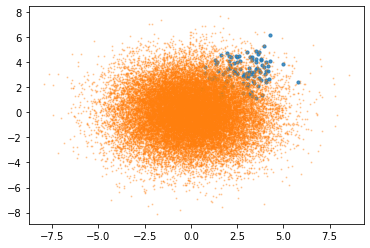

In [1]:
import numpy as np
import  matplotlib.pyplot as plt
import sys
from scipy.stats import kde
from tqdm import tqdm

sys.path.insert(0, '../Modules')
import erqScaling
import erqMedSpec
import os
mean = [0,0]; cov=[[4,0],[0,4]];
X1 = np.random.multivariate_normal(mean, cov, 30000)

mean = [3,3]; cov=[[1,0],[0,1]];
X2= np.random.multivariate_normal(mean, cov, 100)

X_all = np.concatenate((X1,X2), axis=0)
plt.scatter(X2[:,0], X2[:,1], alpha=0.8, s=10)
plt.scatter(X1[:,0], X1[:,1], alpha=0.3, s=1)
plt.show()

In [2]:
X_all = X1
data_0=X_all
(data, minData, rangeData) =  erqScaling.MinMaxScaler(data_0)
Main_center = np.median(data, axis=0)
ERQ = data[((X_all[:,0]>=2.5) & (X_all[:,1]>=2.5))]

enclosing_ratio=0.85; resolution=1000; ngrids=500; 
opening_angle, ERQ_direction = erqMedSpec.opening_angle_finder(ERQ, Main_center, enclosing_ratio, resolution)


#  Obtaining Point A and B for the ERQ wedge
x_erq, y_erq= np.median(ERQ, axis=0)  #center of ERQ population 
r_erq = np.sqrt((x_erq-Main_center[0])**2 + (y_erq-Main_center[1])**2)  # ERQ radius 

A= [0,0]
B= [0,0]
ext=2
A[0] = Main_center[0] + r_erq*ext*np.cos(ERQ_direction+opening_angle)
B[0] = Main_center[0] + r_erq*ext*np.cos(ERQ_direction-opening_angle)
A[1] = Main_center[1] + r_erq*ext*np.sin(ERQ_direction+opening_angle)
B[1] = Main_center[1] + r_erq*ext*np.sin(ERQ_direction-opening_angle)

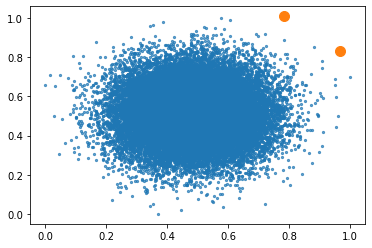

In [3]:
plt.scatter(data[:,0],data[:,1], s=5, alpha=0.7)
plt.scatter([A[0],B[0]],[A[1],B[1]], s=100)
plt.show()

Contour plot...


<ipython-input-4-b9443e097a65>:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)
<ipython-input-4-b9443e097a65>:42: UserWarning: The following kwargs were not used by contour: 'c'
  c = ax.contour(xi, yi, zi.reshape(xi.shape), levels=levels, alpha=0.6, c='black')
  1%|          | 228/30000 [00:00<00:13, 2276.33it/s]

hull...


100%|██████████| 6/6 [00:00<00:00, 74.77it/s]


plotting


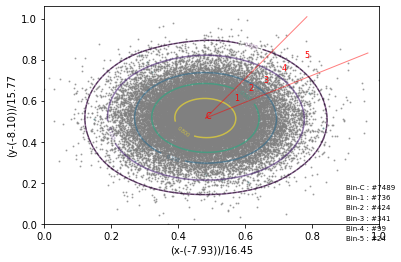

In [4]:
bw=3 # bandwidth ratio for the default value
dir = 'MockLOF1G/'
wdg = 0
if os.path.exists(dir)==False:
    os.system('mkdir -p ' + dir)
    

levels = np.array([0.03, 0.1, .3, 0.5, 0.8])

# bin_label, bin_pop, tip_label = erqMedSpec.KDE_Bin2D(data, rangeData, minData, 2.5, 2.5,\
#                                           ngrids,  bw, levels, \
#                                           A, B, \
#                                           True,[1.3],\
#                                           %(enclosing_ratio, bw, wdg), \
#                                           True, , \
#       
#                                     None)
expansion =[1.3]
path =dir+'Bins-ratio-%.2f-bw-%.2f-wdg-%1d.png'%(enclosing_ratio, bw, wdg)
x_label = '(x-(%.2f))/%.2f' %(minData[0], rangeData[0])
y_label = '(y-(%.2f))/%.2f' %(minData[1], rangeData[1])
tit= None
tip=True
expansion_handle = False
ngrid=100
sample=data
x, y = data.T
k = kde.gaussian_kde(data.T)
k.set_bandwidth(bw_method=k.factor*bw)
print('Contour plot...')
xi, yi = np.mgrid[x.min():x.max():ngrid*1j, y.min():y.max():ngrid*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
zi /=max(zi)
density = np.array(k(sample.T))
density/=max(density)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
fig=plt.figure()
plt.cla()
ax = fig.add_subplot(111)
c = ax.contour(xi, yi, zi.reshape(xi.shape), levels=levels, alpha=0.6, c='black')
ax.clabel(c, fontsize=5)
segments = c.allsegs

# finding the contours
lines = []
nContours = len(levels)
for i in range(nContours):

        l = np.size(np.array(segments[i]))
        line = np.reshape(segments[i], (int(l/2),2))
        lines.append(line) # contours are added to lines regardless of their length

if expansion_handle==True:
        for i in range(len(expansion)):

                line_exp = erqMedSpec.ContourExpantion(lines[i], expansion[i])
                lines.insert(0, line_exp)


lines=np.array(lines)
nContours = len(lines)
# for i in range(nContours):

center=np.empty([2])
center[0] = np.median(sample[:,0])
center[1] = np.median(sample[:,1])

bin_label=np.zeros([len(sample)])
nBins = nContours +1
bin_pop=np.zeros([nBins])
bin_med_position=np.zeros([nBins,2])
tip_label=np.zeros([len(sample)])
tip_pop=0



#A, B = edger(sample, center, wedge_direction, opening_angle)
color=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
print('hull...')
sample0=sample-center
r_max_plotting=-100
ind_in_triangle=[]
for i in tqdm(range(len(sample))):

        if(tip==True):
                # if(in_hull(lines[-1], sample[i,:])==True):
                if(erqMedSpec.cn_PnPoly(lines[nContours-1], sample[i,:])==1):
                        tip_pop+=1
                        tip_label[i]=1

        if (erqMedSpec.in_triangle(A,B, center, sample[i,:], 1e-8)==True):
                ind_in_triangle.append(i)
                # r=np.sqrt(sample0[i,0]**2+sample0[i,1]**2)
                # if(r>r_max_plotting): r_max_plotting=r
                for j in range(0, nBins):
                        Contour_ind = (nContours-1) -j


                        if(j==0): # the inner most bin

                                if(erqMedSpec.cn_PnPoly(lines[Contour_ind], sample[i,:])==1):
                                        bin_label[i]=j+1
                                        bin_pop[j] +=1


                        if(0<j<nBins-1): # intermediate contours

                                if( (erqMedSpec.cn_PnPoly(lines[Contour_ind], sample[i,:]) ==  1) and (erqMedSpec.cn_PnPoly(lines[Contour_ind+1], sample[i,:])==0) ):
                                        bin_label[i]=j+1
                                        bin_pop[j] +=1

                        if(j==nBins-1): # the bin out of expanded contour
                                if(erqMedSpec.cn_PnPoly(lines[0],sample[i,:])==0):
                                        bin_label[i]=j+1
                                        bin_pop[j] +=1
print('plotting')
# plt.clf()
# for i in tqdm(range(len(sample))):
#         for j in range(0,nBins):
#                 plt.scatter(sample[i,0], sample[i,1], c=color[j])


sample_in_traingle = sample[ind_in_triangle]
plt.plot([center[0], A[0] ], [center[1], A[1]], ls='-', c='r', alpha=0.5, lw=1)
plt.plot([center[0], B[0]  ], [center[1], B[1]], ls='-', c='r', alpha=0.5, lw=1)
#plt.plot([A[0], B[0] ], [A[1], B[1]], c='r', alpha=0.5)
# plt.plot([center[0], (A[0]+B[0]-2*center[0])*0.4], [center[1], (A[1]+B[1]-2*center[1])*0.4], lw=2)
# x_erq_p=(x_erq -minData[0])/rangeData[0] 
# y_erq_p=(y_erq -minData[1])/rangeData[1] 
# plt.plot([x_erq_p,max(sample[:,0])], [y_erq_p,y_erq_p], ls='--', c='black', lw=1)
# plt.plot([x_erq_p,x_erq_p], [y_erq_p, max(sample[:,1])], ls='--', c='black', lw=1)
plt.scatter(data[-100:,0],data[-100:,1], s=1, alpha=0.4, c= 'C9')
plt.scatter(data[0:30000,0],data[0:30000,1], s=1, alpha=0.6, c='grey')# plt.xlim(-0.1, 1.1)
# plt.ylim(-0.1, 1.1)
for i in range(0, nContours):
        l = lines[i]

        if (i<len(expansion)):
                plt.plot(l[:,0], l[:,1], c = 'black', ls='--', alpha=0.5, lw=1)
        # else:
                # plt.plot(l[:,0], l[:,1], c = 'black', ls='-', alpha=0.5, lw=1)




# # # plb.axis('equal')
# ticks_x = ticker.FuncFormatter(lambda x, 
#                            pos: '{0:g}'.format(round(x*rangeData[0]+ minData[0], 2)))
# ax.xaxis.set_major_formatter(ticks_x)

# ticks_y = ticker.FuncFormatter(lambda x, 
#                           pos: '{0:g}'.format(round(x*rangeData[1]+minData[1],2)))
# ax.yaxis.set_major_formatter(ticks_y)
plt.xlabel(x_label)
plt.ylabel(y_label)
# r = np.max(sample, axis=0) - np.min(sample, axis=0)
# plt.xlim(0,1)
# plt.ylim(0,1)
for j in tqdm(range(nBins)):  
        if(j>0):
                x=[]; y=[]
                for i in range(len(sample)):
                        if (bin_label[i]==j+1):
                                x.append(sample[i,0])
                                y.append(sample[i,1])

                bin_med_position0 = np.median(x)
                bin_med_position1 = np.median(y)
                plt.text(bin_med_position0, bin_med_position1, str(j), fontsize=8, color='red')

                plt.text(.9, 0.17-j*0.05, 'Bin-'+ str(j)+ ' : #'+str(int(bin_pop[j])),fontsize=7, color='black' )
        else:
                plt.text(.9, .17, 'Bin-C' + ' : #'+str(tip_pop),fontsize=7, color='black' )
                plt.text(np.median(sample[:,0]), np.median(sample[:,1]), 'C', fontsize=8, color='red')
# if(expansion_handle==True): plt.title(str(round(expansion[0],1))+', '+ str(round(expansion[1],1))+ ', ' + str(round(expansion[2],1)))
# plt.axis('equal')
plt.savefig(path, bbox_inches='tight', format='png', dpi=200)
plt.show()
plt.close()



Contour plot...


<ipython-input-4-b9443e097a65>:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)
<ipython-input-4-b9443e097a65>:42: UserWarning: The following kwargs were not used by contour: 'c'
  c = ax.contour(xi, yi, zi.reshape(xi.shape), levels=levels, alpha=0.6, c='black')
  1%|          | 228/30000 [00:00<00:13, 2276.33it/s]

hull...


100%|██████████| 6/6 [00:00<00:00, 74.77it/s]


plotting


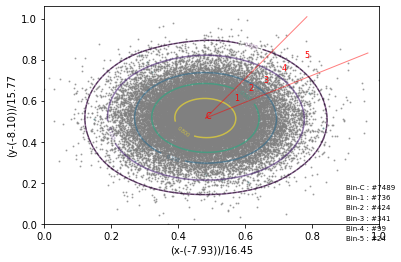

In [4]:
def get_label(data)

    x, y = data.T
    k = kde.gaussian_kde(data.T)
    k.set_bandwidth(bw_method=k.factor*bw)
    print('Contour plot...')
    xi, yi = np.mgrid[x.min():x.max():ngrid*1j, y.min():y.max():ngrid*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    zi /=max(zi)
    density = np.array(k(sample.T))
    density/=max(density)
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    fig=plt.figure()
    plt.cla()
    ax = fig.add_subplot(111)
    c = ax.contour(xi, yi, zi.reshape(xi.shape), levels=levels, alpha=0.6, c='black')
    ax.clabel(c, fontsize=5)
    segments = c.allsegs

    # finding the contours
    lines = []
    nContours = len(levels)
    for i in range(nContours):

            l = np.size(np.array(segments[i]))
            line = np.reshape(segments[i], (int(l/2),2))
            lines.append(line) # contours are added to lines regardless of their length

    if expansion_handle==True:
            for i in range(len(expansion)):

                    line_exp = erqMedSpec.ContourExpantion(lines[i], expansion[i])
                    lines.insert(0, line_exp)


    lines=np.array(lines)
    nContours = len(lines)
    # for i in range(nContours):

    center=np.empty([2])
    center[0] = np.median(sample[:,0])
    center[1] = np.median(sample[:,1])

    bin_label=np.zeros([len(sample)])
    nBins = nContours +1
    bin_pop=np.zeros([nBins])
    bin_med_position=np.zeros([nBins,2])
    tip_label=np.zeros([len(sample)])
    tip_pop=0

    print('hull...')
    sample0=sample-center
    r_max_plotting=-100
    ind_in_triangle=[]
    for i in tqdm(range(len(sample))):

            if(tip==True):
                    # if(in_hull(lines[-1], sample[i,:])==True):
                    if(erqMedSpec.cn_PnPoly(lines[nContours-1], sample[i,:])==1):
                            tip_pop+=1
                            tip_label[i]=1

            if (erqMedSpec.in_triangle(A,B, center, sample[i,:], 1e-8)==True):
                    ind_in_triangle.append(i)
                    # r=np.sqrt(sample0[i,0]**2+sample0[i,1]**2)
                    # if(r>r_max_plotting): r_max_plotting=r
                    for j in range(0, nBins):
                            Contour_ind = (nContours-1) -j


                            if(j==0): # the inner most bin

                                    if(erqMedSpec.cn_PnPoly(lines[Contour_ind], sample[i,:])==1):
                                            bin_label[i]=j+1
                                            bin_pop[j] +=1


                            if(0<j<nBins-1): # intermediate contours

                                    if( (erqMedSpec.cn_PnPoly(lines[Contour_ind], sample[i,:]) ==  1) and (erqMedSpec.cn_PnPoly(lines[Contour_ind+1], sample[i,:])==0) ):
                                            bin_label[i]=j+1
                                            bin_pop[j] +=1

                            if(j==nBins-1): # the bin out of expanded contour
                                    if(erqMedSpec.cn_PnPoly(lines[0],sample[i,:])==0):
                                            bin_label[i]=j+1
                                            bin_pop[j] +=1
    return bin_label, bin_pop, tip_label, tip_pop


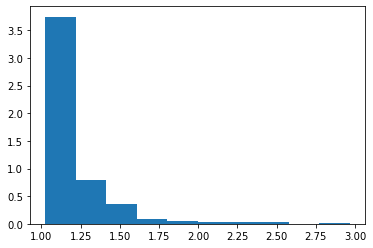

In [5]:
from sklearn.neighbors import LocalOutlierFactor as LOF

nBin=6
clf= LOF(n_neighbors=150,  n_jobs=8)
clf.fit_predict(data)
LOFScores= -clf.negative_outlier_factor_
# plt.hist(LOFScores, density=True)
plt.hist(LOFScores[((X_all[:,0]>=2.5) & (X_all[:,1]>=2.5))], density=True)
plt.show()

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

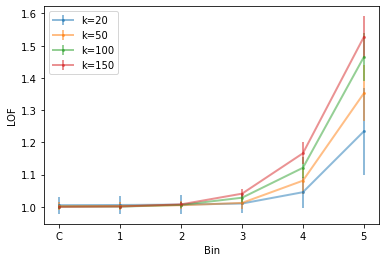

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

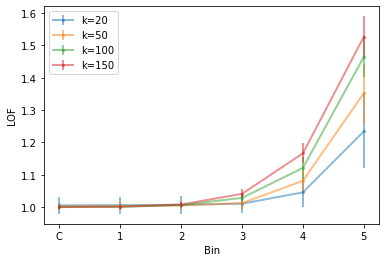

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

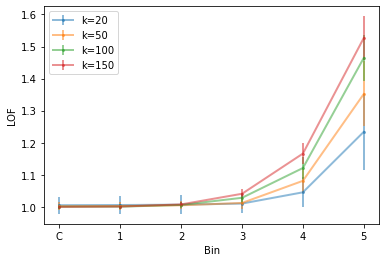

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

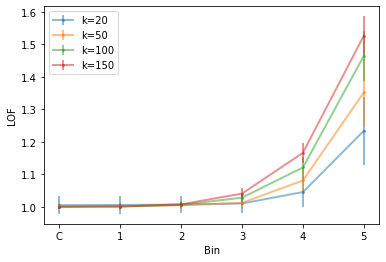

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

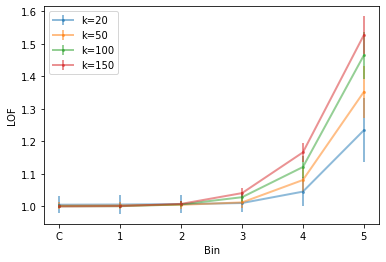

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

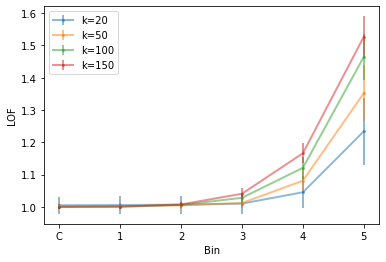

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

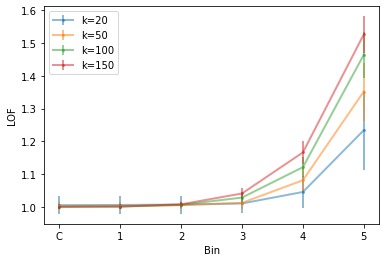

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

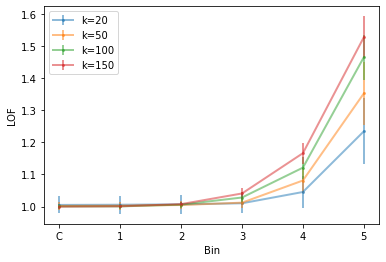

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

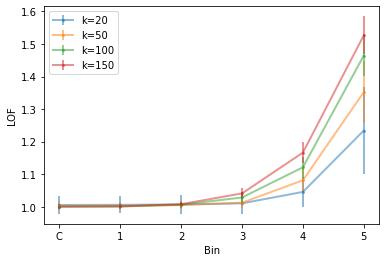

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

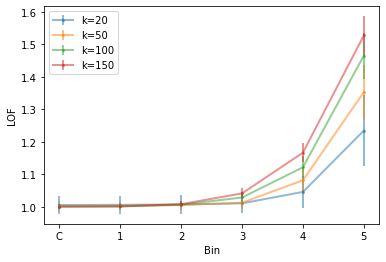

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

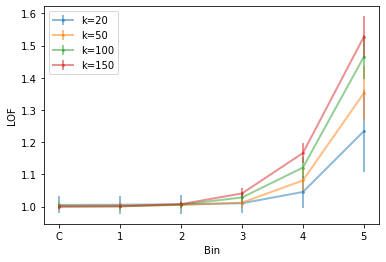

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

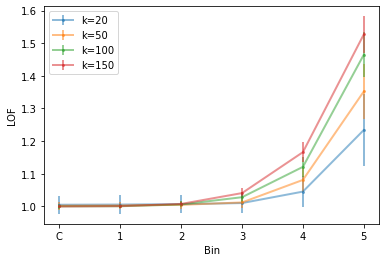

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

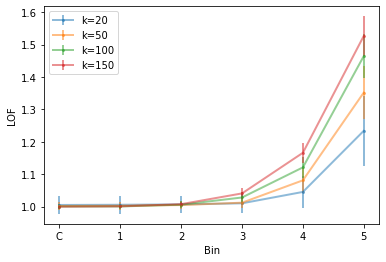

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

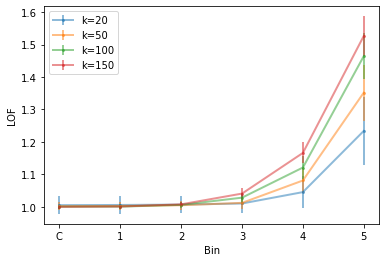

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

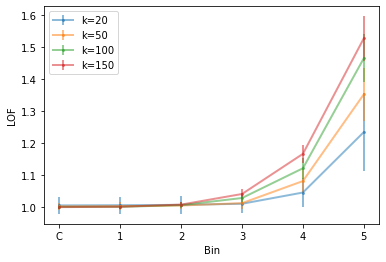

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packag

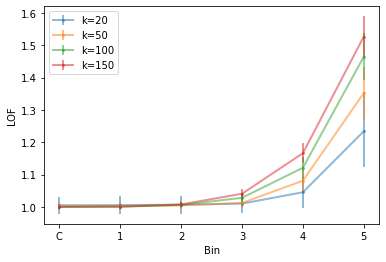

  0%|          | 0/30000 [00:00<?, ?it/s]/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/reza/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  4%|▍         | 4/100 [00:01<00:37,  2.55it/s]


KeyboardInterrupt: 

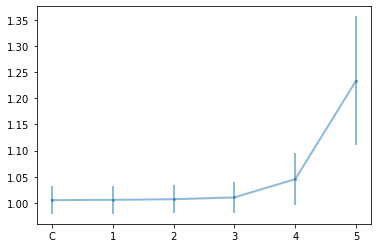

In [9]:
for ii in range(1,20):
    cc=-1
    from matplotlib import cm

    for k in [20, 50, 100, 150]:

        clf= LOF(n_neighbors=k,  n_jobs=7)
        clf.fit_predict(data)
        LOFScores= -clf.negative_outlier_factor_
        BootSize=np.int32(len(data))
        LOFScores_boot=np.zeros([100,len(data)])
        for boot in tqdm(range(100)):
            rand_ind = np.random.choice(range(len(data)), BootSize, replace=True)
            test= data[rand_ind,:]
            clf= LOF(n_neighbors=k,  n_jobs=-1)
            clf.fit_predict(test)
            LOFScores_boot[boot,rand_ind] = -clf.negative_outlier_factor_
            LOFScores_boot[boot,~rand_ind] = 0

        ErrLOF = np.zeros(len(data))
        MeanLOFBoot = np.zeros(len(data))
        for i in tqdm(range(len(data))):

            LOF_pool = LOFScores_boot[:,i]
            ErrLOF[i] = np.std(LOF_pool[LOF_pool>=1])
            # MeanLOFBoot[i] = np.mean(LOF_pool[LOF_pool<=-1])

        LOFScoresMed=[]
        ErrLOFScoresMed=[]
        MeanLOFBootMed=[]

        #  Median properties in each bin
        for b in range(1,nBin+1):
            if(b>1):
                mask = (bin_label==b)

            else:
                mask = (tip_label==1)

            LOFScoresMed.append(np.median(LOFScores[mask]))
            ErrLOFScoresMed.append(np.nanmedian(ErrLOF[mask]))
            MeanLOFBootMed.append(np.median(MeanLOFBoot[mask]))


        plt.errorbar(['C', '1', '2', '3', '4' , '5'], LOFScoresMed[0:nBin], yerr=ErrLOFScoresMed[0:nBin], alpha=0.5, marker='o', lw=2,
                     markersize=2, label='k=%d'%k)

    plt.legend()
    plt.xlabel('Bin')
    plt.ylabel('LOF')
    plt.savefig(dir+'LOF-mock-%d.png'%ii, dpi=200, format='png')
    plt.show()